In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'
import h5py
from second_cumulant import second_cumulant, all_second_cumulants
from file_to_field import all_fields_from_file

# Getting Data from DNS to CE2

First step is to extract all fields from DNS, create Dedalus fields:

In [2]:
#filename = 'scratch/busse_annulus_ra7.60e+04_beta2.80e+03_C0.00e+00_Pr1.00e+00_filter5.00e-01_nx256_ny64_CFL/snapshots/snapshots_s1.h5'
filename = 'scratch/busse_annulus_ra1.00e+08_beta7.07e+05_C3.16e-01_Pr1.00e+00_filter5.00e-01_nx512_ny256_CFL_xy/snapshots/snapshots_s1.h5'

In [3]:
df = h5py.File(filename,'r')

This function allows us to do that.

Note that here, I've used a DNS run with the `--xy` flag, so it's 

```
['Fourier', 'SinCos'] # for x, y
```
instead of the other way around. Be careful, very few DNS runs have this option. If you want to start a CE2 run from a DNS output, you have to re-run the DNS with `--xy`.

In [4]:
fields = all_fields_from_file(filename,['Fourier', 'SinCos'], meta={'y':{'constant': False, 'parity': -1}}, index=-1)

In [5]:
df['tasks'].keys()

<KeysViewHDF5 ['psi', 'theta', 'theta_fluct', 'theta_kspace', 'u_x', 'u_y', 'zeta', 'zeta_fluct', 'zeta_kspace']>

All we need are $\psi$ and $\Theta$:

In [6]:
psi, theta = fields[0:2]

Now, we can test taking the second cumulant for just a single $y$ index (note that this takes either an int, in which case it takes the second cumulant with regard to a given grid cell, or a float in which case it interpolates to that $y$ position).

In [7]:
theta_2c = second_cumulant(31, theta,layout='xy')

/home/joishi/miniconda3/envs/dedalus/lib/python3.7/site-packages/dedalus/core/distributor.py:334: ComplexWarning: Casting complex values to real discards the imaginary part
  gdata[:] = cdata[axslice(self.axis, 0, 1)]


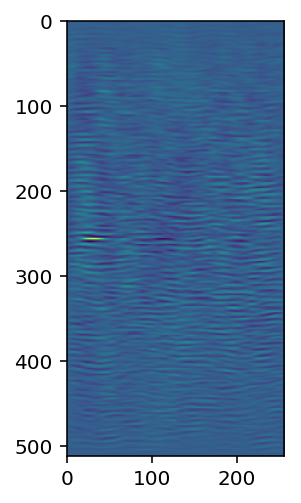

In [8]:
plt.imshow(theta_2c)

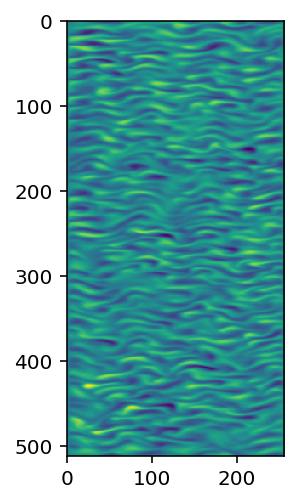

In [9]:
plt.imshow(theta['g'])

Calculate the full second cumulant.

In [10]:
ctt = all_second_cumulants(theta,g=theta, layout='xy')

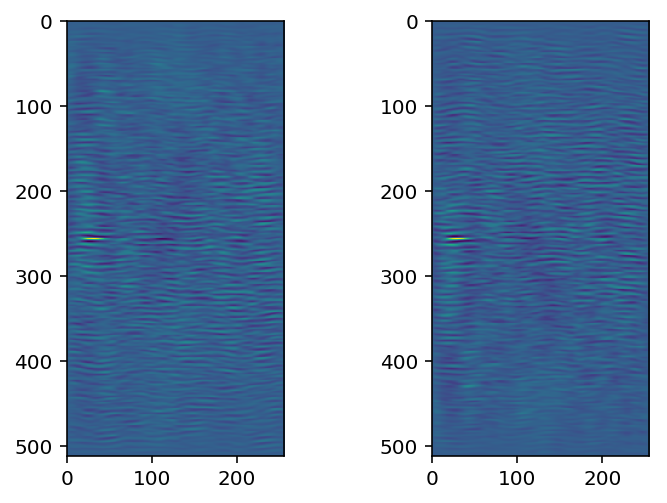

In [11]:
plt.subplot(121)
plt.imshow(ctt[:,:,31])
plt.subplot(122)
plt.imshow(ctt[:,31,:])

<strike>This is $c_{\theta \theta}(y_1, y_2, \xi)$. Unfortunately, we need $c_{\theta \theta}(\xi, y_1, y_2)$ to feed into CE2.</strike>

Update: I gave an option to the DNS code to swap x and y in the domain, so we can just get what we want without fucking around.

Now some scaffolding for the eventual function

In [12]:
out_fields = ['cs','ct', 'css', 'ctt', 'cts', 'cst']
ingredients = ((psi, psi),(theta, theta), (theta, psi), (psi, theta))
inputs = dict(zip(out_fields[2:],ingredients))
for k,v in inputs.items():
    print("k = {}, v = {}".format(k,v))

k = css, v = (<Field 46914376872904>, <Field 46914376872904>)
k = ctt, v = (<Field 46914362058008>, <Field 46914362058008>)
k = cts, v = (<Field 46914362058008>, <Field 46914376872904>)
k = cst, v = (<Field 46914376872904>, <Field 46914362058008>)


In [13]:
ctt.shape

(512, 256, 256)

Let's test the output from our conversion program. After the work below to set up `full` in the cumulant calculation and the required `set_scales` conversion, everything seems OK!

In [38]:
ce2_file = h5py.File("ce2_test_output_nx512/ce2_test_output_nx512_s1.h5","r")

In [39]:
ce2_file['tasks']['ct']

<HDF5 dataset "ct": shape (1, 1, 256, 256), type "<f8">

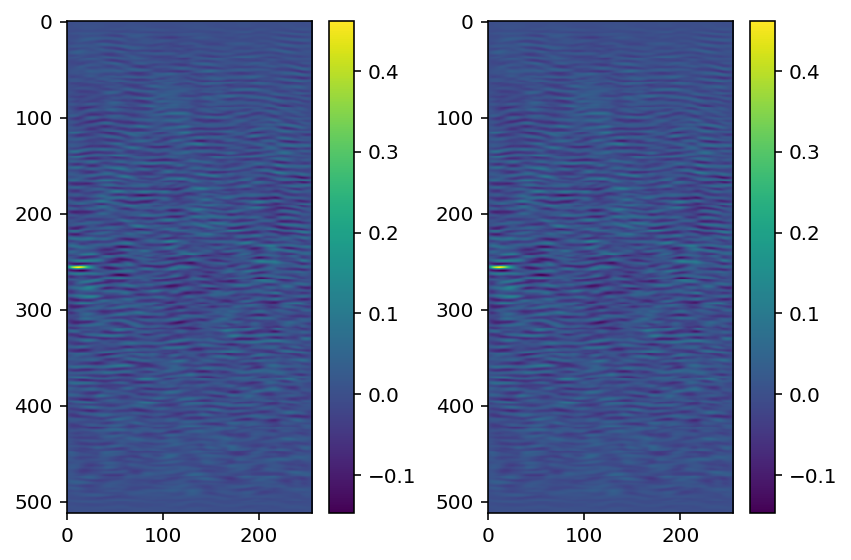

In [40]:
plt.subplot(121)
plt.imshow(ce2_file['tasks']['ctt'][0,:,10,:])
plt.colorbar()
plt.subplot(122)
plt.imshow(ctt[:,10,:])
plt.colorbar()
plt.tight_layout()

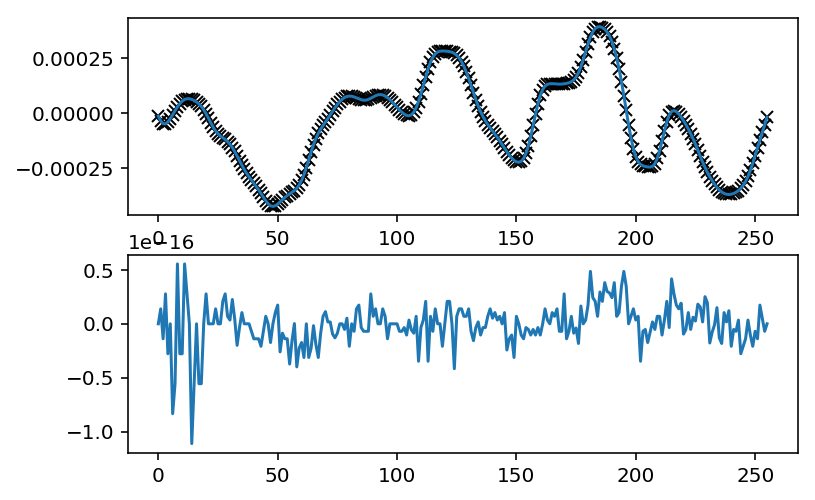

In [41]:
plt.subplot(211)
plt.plot(ce2_file['tasks']['ctt'][0,0,:,10],'kx')
plt.plot(ctt[0,:,10])
plt.subplot(212)
plt.plot(ce2_file['tasks']['ctt'][0,0,:,10]-ctt[0,:,10])


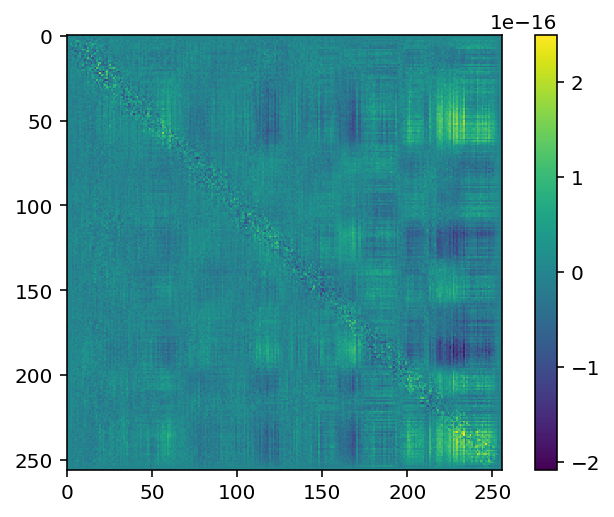

In [42]:
plt.imshow(ce2_file['tasks']['ctt'][0,0,:,:]- ctt[0,:,:])
plt.colorbar()

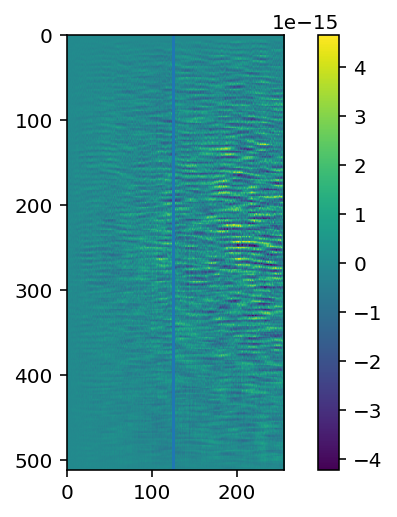

In [43]:
idx= 20
plt.imshow(ce2_file['tasks']['ctt'][0,:,idx,:]- ctt[:,idx,:])
plt.axvline(125)
plt.colorbar()

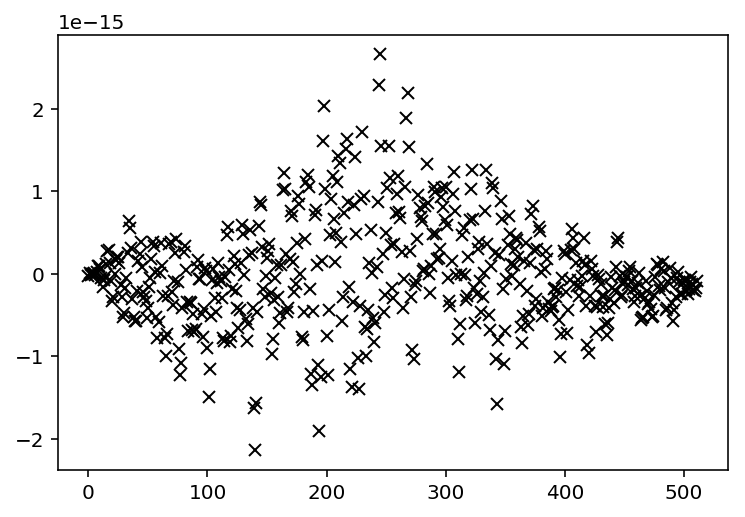

In [44]:
plt.plot(ce2_file['tasks']['ctt'][0,:,idx,125]- ctt[:,idx,125],'kx')


(0, 30)

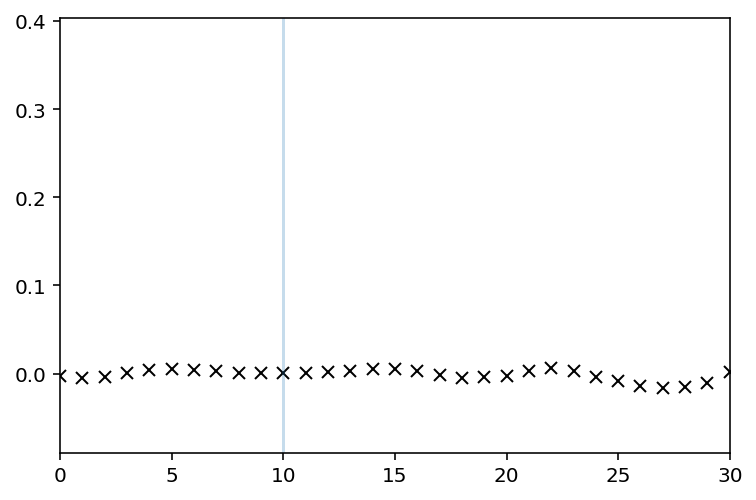

In [45]:
plt.plot(np.roll(ce2_file['tasks']['ctt'][0,:,125,125],10),'kx')
plt.axvline(10,alpha=0.25)
plt.xlim(0,30)

In [46]:
np.linalg.norm(ce2_file['tasks']['ctt'][0,:,:,:]- ctt[:,:,:])

3.067920461023337e-12

In [47]:
np.allclose(ce2_file['tasks']['ctt'][0,...], ctt)

True

In [48]:
test_df = h5py.File("test_out.h5","r")

In [49]:
np.allclose(ctt,test_df['ctt'])

False

In [50]:
np.linalg.norm(test_df['ctt']-ctt)

229.89037214278497

## End Effects

For cross correlation, the `same` option to `np.correlate` does not guarantee periodicity. Does `full`?

For `full`, we need to scale from $2N - 1$ points back to $N$ points. This can be done using Dedalus itself **if N is a power of two** (or something else that allows resolves OK in floating point. 

In [51]:
test_1024 = (1024/2047 * 2047).is_integer()
test_512 = (512/1023 * 1023).is_integer()

print("1024: {}".format(test_1024))
print("512: {}".format(test_512))

1024: True
512: True


In [52]:
import dedalus.public as de

In [53]:
nz = 512
n_full = 2*nz -1
zb = de.Fourier('z',n_full)
td = de.Domain([zb,], grid_dtype=np.float64)
fz = td.new_field()
z = zb.grid(scale=nz/n_full)
#fz.set_scales(nz/n_full)

In [54]:
fz.domain.bases[0].coeff_size

512

In [55]:
z.shape

(512,)

In [56]:
fz.set_scales(1)

Try a simple fuction:

In [68]:
signal_a = np.sin(2*z)
signal_b = np.sin(3*z)+0.2*np.sin(17*z)
cff = np.correlate(signal_a,signal_b, mode='full')
cff_same = np.correlate(signal_a,signal_b, mode='same')

In [76]:
def calc_spec(f):
    coeff = np.fft.rfft(f)
    return (coeff*coeff.conj()).real

Check that both signals are themselves periodic...

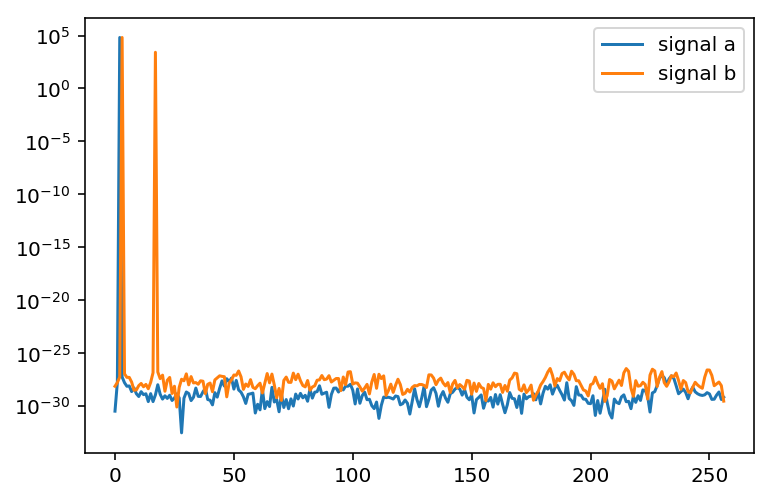

In [78]:
a_spec = calc_spec(signal_a)
b_spec = calc_spec(signal_b)

plt.semilogy(a_spec, label='signal a')
plt.semilogy(b_spec, label='signal b')
#plt.ylim(1e-8,1e9)
plt.legend()

First, confirm that using `same`, this is *not* periodic but with `full` it appears to be.

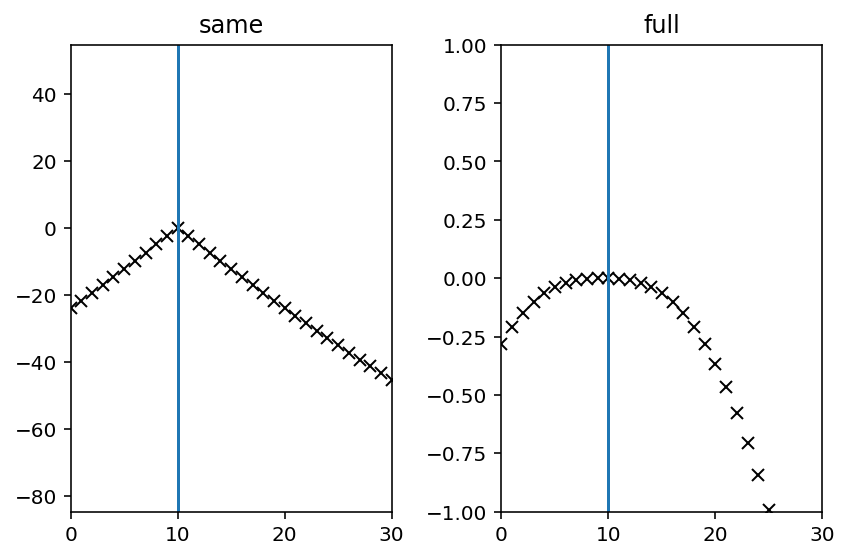

In [74]:
plt.subplot(121)
plt.plot(np.roll(cff_same,10),'kx')
plt.xlim(0,30)
plt.axvline(10)
plt.title("same")
plt.subplot(122)
plt.plot(np.roll(cff,10),'kx')
plt.xlim(0,30)
plt.ylim(-1,1)
plt.axvline(10)
plt.title("full")
plt.tight_layout()

In order to test if this is periodic, the easiest way to do so is to look at the spectrum. If it is not periodic, the spectrum will not reach machine precision.

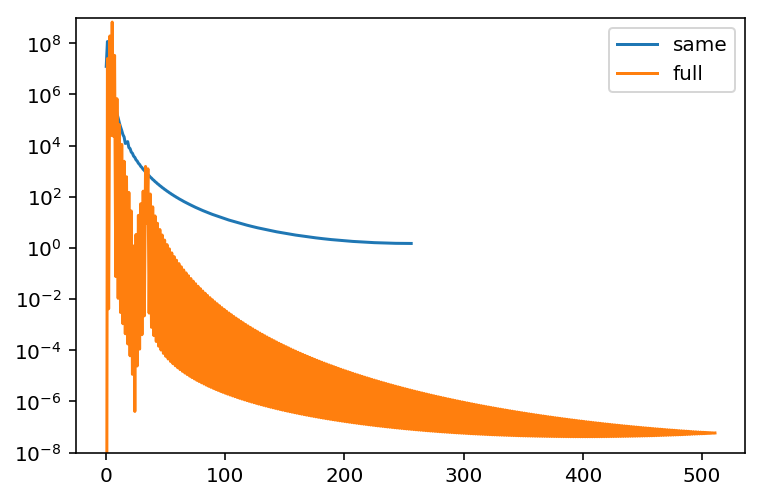

In [77]:
same_spec = calc_spec(cff_same)
full_spec = calc_spec(cff)

plt.semilogy(spec, label='same')
plt.semilogy(full_spec, label='full')
plt.ylim(1e-8,1e9)
plt.legend()

Sure enough, full decays to machine precision, but same does not.

Finally, we can put it all together by setting scales back to the original grid size:

In [ ]:
fz.set_scales(nz/n_full, keep_data=True)

print("fz size: {}".format(fz['g'].shape))

In [ ]:
z_full = zb.grid(scale=1)

In [ ]:
plt.plot(z_full,cff,label='2N - 1 data points')
plt.plot(z, fz['g'],'kx',alpha=0.4,label='N data points')
plt.legend()
plt.xlabel("z")
plt.ylabel(r"$c_{ff}$")